In [16]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pytearcat as pt


In [17]:
# Define coordinates and metric
tau, x, y, z = pt.coords('tau,x,y,z')
a = pt.fun('a', 'tau')
Phi = pt.fun('Phi', 'x,y,z')
ds2 = 'ds2 = a**2*(-(1 + 2*Phi)*dtau**2 + (1 - 2*Phi)*(dx**2 + dy**2 + dz**2))'
g = pt.metric(ds2)
Chr = pt.christoffel(First_kind=False)


Remember that the time coordinate must be the first coordinate.
Function a(tau) is already defined
Function Phi(x,y,z) is already defined

Dimension = 4
Coordinates = tau,x,y,z
Metric defined successfully: 



<IPython.core.display.Math object>

Matrix([
[-2*Phi(x, y, z)*a(tau)**2 - a(tau)**2,                                     0,                                     0,                                     0],
[                                    0, -2*Phi(x, y, z)*a(tau)**2 + a(tau)**2,                                     0,                                     0],
[                                    0,                                     0, -2*Phi(x, y, z)*a(tau)**2 + a(tau)**2,                                     0],
[                                    0,                                     0,                                     0, -2*Phi(x, y, z)*a(tau)**2 + a(tau)**2]])

<IPython.core.display.Latex object>

In [18]:
# Define potential and derivatives
m = 0.06  # Reduced mass for weak-field approximation

def phi(x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2)
    return -m / r if r > 1e-10 else 0

def dphi_dx(x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2)
    return m * x / r**3 if r > 1e-10 else 0

def dphi_dy(x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2)
    return m * y / r**3 if r > 1e-10 else 0

def dphi_dz(x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2)
    return m * z / r**3 if r > 1e-10 else 0


In [19]:
# Set initial conditions
beta = np.pi / 2
alpha = 0.0
tau0 = 0.0
x0 = 50.0
y0 = 5.0
z0 = 5.0
a0 = 1.0

phi0 = phi(x0, y0, z0)
g00_0 = -a0**2 * (1.0 + 2.0 * phi0)
g11_0 = a0**2 * (1.0 - 2.0 * phi0)
g22_0 = a0**2 * (1.0 - 2.0 * phi0)
g33_0 = a0**2 * (1.0 - 2.0 * phi0)

ktau_0 = 1.0 / np.sqrt(np.abs(g00_0))
kx_0 = np.cos(alpha) * np.sin(beta) / np.sqrt(np.abs(g11_0))
ky_0 = np.sin(alpha) * np.sin(beta) / np.sqrt(np.abs(g22_0))
kz_0 = np.cos(beta) / np.sqrt(np.abs(g33_0))

h0 = [tau0, ktau_0, x0, kx_0, y0, ky_0, z0, kz_0, a0]


In [20]:
# Cosmological parameters
wm = 0.3
wd = 0.7
H0 = 0.070894407 * 3.26 / (1000 * 0.67556)


In [21]:
# Define the geodesic function
def geodesic(h, l):
    tau, ktau, x, kx, y, ky, z, kz, a = h

    dadtau = H0 * a**2 * np.sqrt(wm / a**3 + wd)
    phi_val = phi(x, y, z)
    dphi_dx_val = dphi_dx(x, y, z)
    dphi_dy_val = dphi_dy(x, y, z)
    dphi_dz_val = dphi_dz(x, y, z)

    den1 = 1.0 + 2.0 * phi_val
    den2 = 1.0 - 2.0 * phi_val

    gamma_000 = dadtau / a
    gamma_001 = dphi_dx_val / den1
    gamma_002 = dphi_dy_val / den1
    gamma_003 = dphi_dz_val / den1
    gamma_010 = gamma_001
    gamma_020 = gamma_002
    gamma_030 = gamma_003
    gamma_011 = (dadtau / a) * (den2 / den1)
    gamma_022 = gamma_011
    gamma_033 = gamma_011

    gamma_100 = dphi_dx_val / den2
    gamma_101 = dadtau / a
    gamma_110 = gamma_101
    gamma_111 = -dphi_dx_val / den2
    gamma_112 = -dphi_dy_val / den2
    gamma_113 = -dphi_dz_val / den2
    gamma_121 = gamma_112
    gamma_122 = dphi_dx_val / den2
    gamma_131 = gamma_113
    gamma_133 = dphi_dx_val / den2

    gamma_200 = dphi_dy_val / den2
    gamma_202 = dadtau / a
    gamma_220 = gamma_202
    gamma_211 = dphi_dy_val / den2
    gamma_212 = -dphi_dx_val / den2
    gamma_221 = gamma_212
    gamma_222 = -dphi_dy_val / den2
    gamma_223 = -dphi_dz_val / den2
    gamma_232 = gamma_223
    gamma_233 = dphi_dy_val / den2

    gamma_300 = dphi_dz_val / den2
    gamma_303 = dadtau / a
    gamma_330 = gamma_303
    gamma_311 = dphi_dz_val / den2
    gamma_313 = -dphi_dx_val / den2
    gamma_322 = dphi_dz_val / den2
    gamma_323 = -dphi_dy_val / den2
    gamma_331 = gamma_313
    gamma_332 = gamma_323
    gamma_333 = -dphi_dz_val / den2

    dhdl = [
        ktau,
        -(gamma_000 * ktau**2 + 2 * gamma_001 * ktau * kx + 2 * gamma_002 * ktau * ky + 2 * gamma_003 * ktau * kz +
          gamma_011 * kx**2 + gamma_022 * ky**2 + gamma_033 * kz**2),
        kx,
        -(gamma_100 * ktau**2 + 2 * gamma_101 * ktau * kx + 2 * gamma_112 * kx * ky + 2 * gamma_113 * kx * kz +
          gamma_111 * kx**2 + gamma_122 * ky**2 + gamma_133 * kz**2),
        ky,
        -(gamma_200 * ktau**2 + 2 * gamma_202 * ktau * ky + 2 * gamma_212 * ky * kx + 2 * gamma_223 * ky * kz +
          gamma_211 * kx**2 + gamma_222 * ky**2 + gamma_233 * kz**2),
        kz,
        -(gamma_300 * ktau**2 + 2 * gamma_303 * ktau * kz + 2 * gamma_313 * kz * kx + 2 * gamma_323 * kz * ky +
          gamma_311 * kx**2 + gamma_322 * ky**2 + gamma_333 * kz**2),
        dadtau * ktau
    ]
    return dhdl


In [22]:
# Affine parameter
l = np.linspace(0, -1000, 20000)  # High resolution

# Integrate
sol = odeint(geodesic, h0, l, rtol=1e-13, atol=1e-15)

tau = sol[:, 0]
ktau = sol[:, 1]
x = sol[:, 2]
kx = sol[:, 3]
y = sol[:, 4]
ky = sol[:, 5]
z = sol[:, 6]
kz = sol[:, 7]
a = sol[:, 8]


In [23]:
# Compute metric components
phi_vals = np.array([phi(x[i], y[i], z[i]) for i in range(len(l))])
g00 = -a**2 * (1 + 2 * phi_vals)
g11 = a**2 * (1 - 2 * phi_vals)
g22 = a**2 * (1 - 2 * phi_vals)
g33 = a**2 * (1 - 2 * phi_vals)

# Null condition
null_condition = g00 * ktau**2 + g11 * kx**2 + g22 * ky**2 + g33 * kz**2


In [24]:
# Diagnostic: Check null condition and potential
print("Max |null_condition|:", np.max(np.abs(null_condition)))
print("Mean |null_condition|:", np.mean(np.abs(null_condition)))
print("Max |Phi|:", np.max(np.abs(phi_vals)))
print("Min r:", np.min(np.sqrt(x**2 + y**2 + z**2)))

# Energy and redshift
E = ktau
redshift = (E * a) - 1


Max |null_condition|: 1.5110569046017375e-13
Mean |null_condition|: 1.1160968023356831e-13
Max |Phi|: 0.008612169618733134
Min r: 6.966885541767361


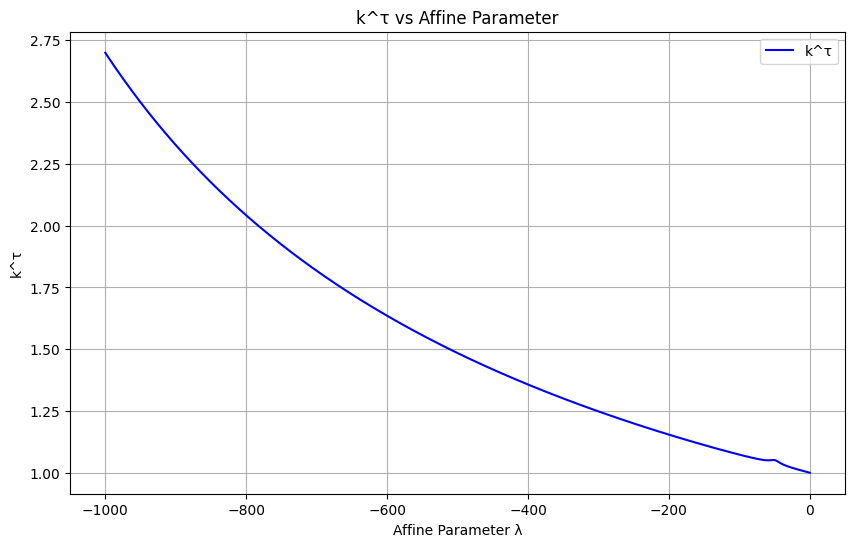

In [25]:
# Diagnostic: Plot k^τ
plt.figure(figsize=(10, 6))
plt.plot(l, ktau, 'b-', label='k^τ')
plt.xlabel('Affine Parameter λ')
plt.ylabel('k^τ')
plt.title('k^τ vs Affine Parameter')
plt.legend()
plt.grid(True)
plt.show()


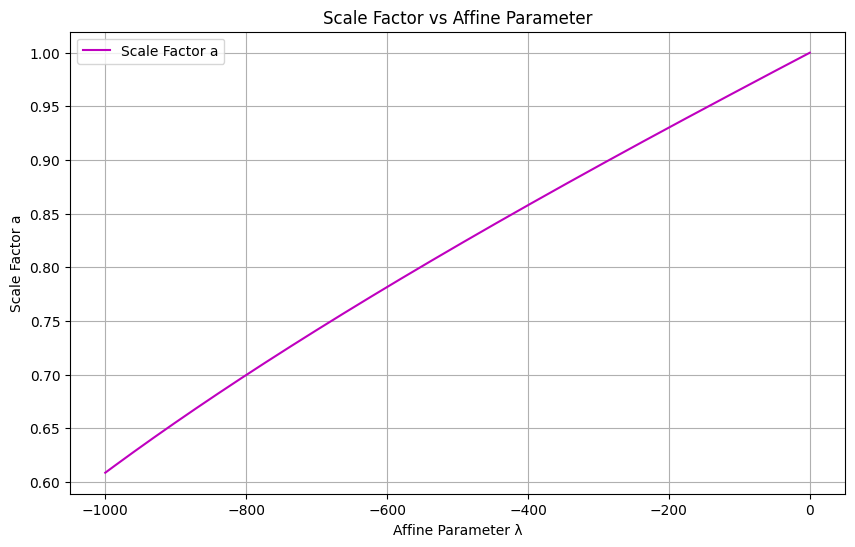

In [26]:
# Diagnostic: Plot scale factor
plt.figure(figsize=(10, 6))
plt.plot(l, a, 'm-', label='Scale Factor a')
plt.xlabel('Affine Parameter λ')
plt.ylabel('Scale Factor a')
plt.title('Scale Factor vs Affine Parameter')
plt.legend()
plt.grid(True)
plt.show()


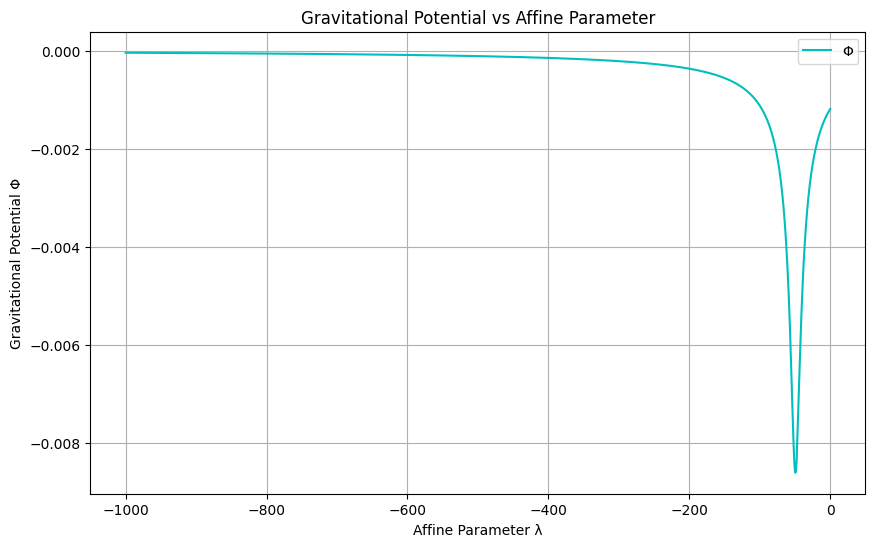

In [27]:
# Diagnostic: Plot gravitational potential
plt.figure(figsize=(10, 6))
plt.plot(l, phi_vals, 'c-', label='Φ')
plt.xlabel('Affine Parameter λ')
plt.ylabel('Gravitational Potential Φ')
plt.title('Gravitational Potential vs Affine Parameter')
plt.legend()
plt.grid(True)
plt.show()


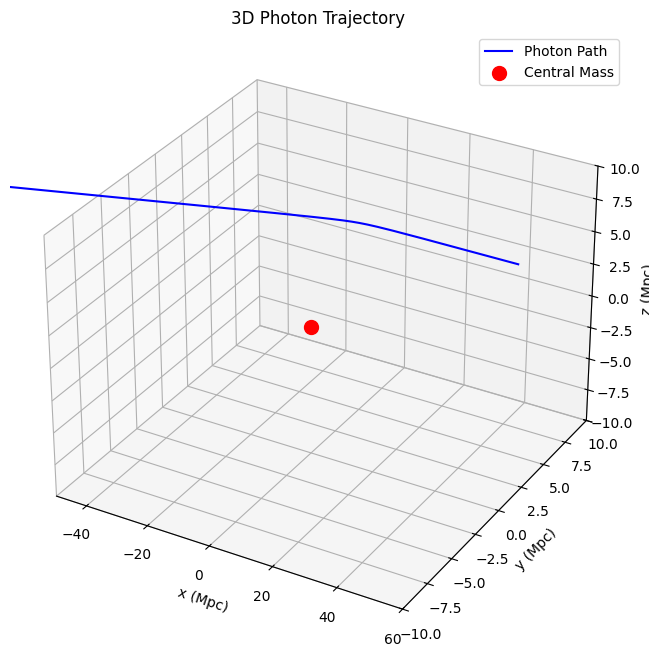

In [28]:
# 3D trajectory plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, color='blue', label='Photon Path')
ax.scatter([0], [0], [0], color='red', s=100, label='Central Mass')
ax.set_xlabel('x (Mpc)')
ax.set_ylabel('y (Mpc)')
ax.set_zlabel('z (Mpc)')
ax.set_xlim([-50, 60])
ax.set_ylim([-10, 10])
ax.set_zlim([-10, 10])
ax.set_title('3D Photon Trajectory')
ax.legend()
ax.grid(True)
plt.show()


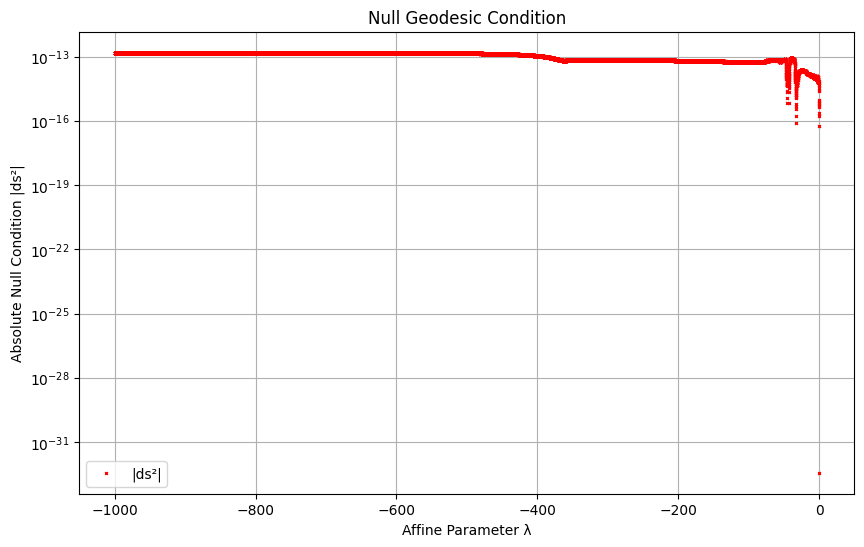

In [29]:
# Null condition plot
plt.figure(figsize=(10, 6))
plt.plot(l, np.abs(null_condition), 'rx', markersize=2, label='|ds²|')
plt.yscale('log')
plt.xlabel('Affine Parameter λ')
plt.ylabel('Absolute Null Condition |ds²|')
plt.title('Null Geodesic Condition')
plt.legend()
plt.grid(True)
plt.show()


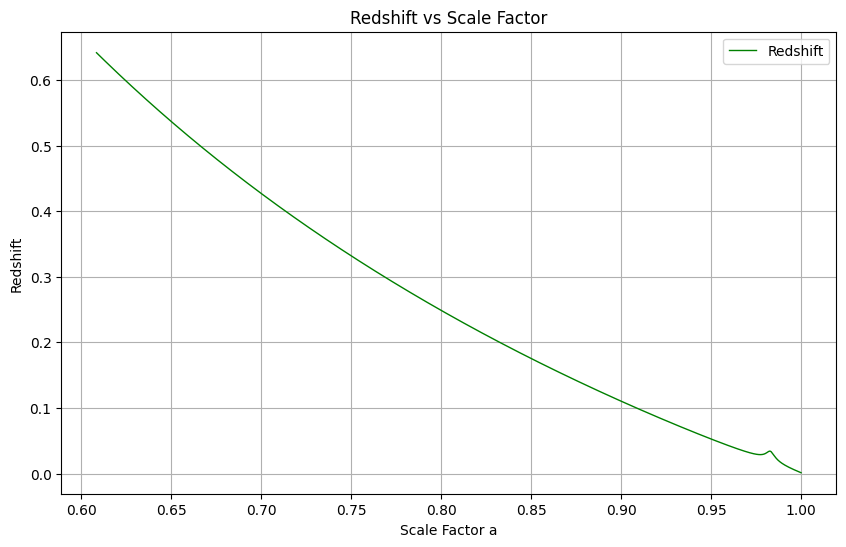

In [30]:
# Redshift plot
plt.figure(figsize=(10, 6))
plt.plot(a, redshift, 'g-', linewidth=1, label='Redshift')
plt.xlabel('Scale Factor a')
plt.ylabel('Redshift')
plt.title('Redshift vs Scale Factor')
plt.legend()
plt.grid(True)
plt.show()


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


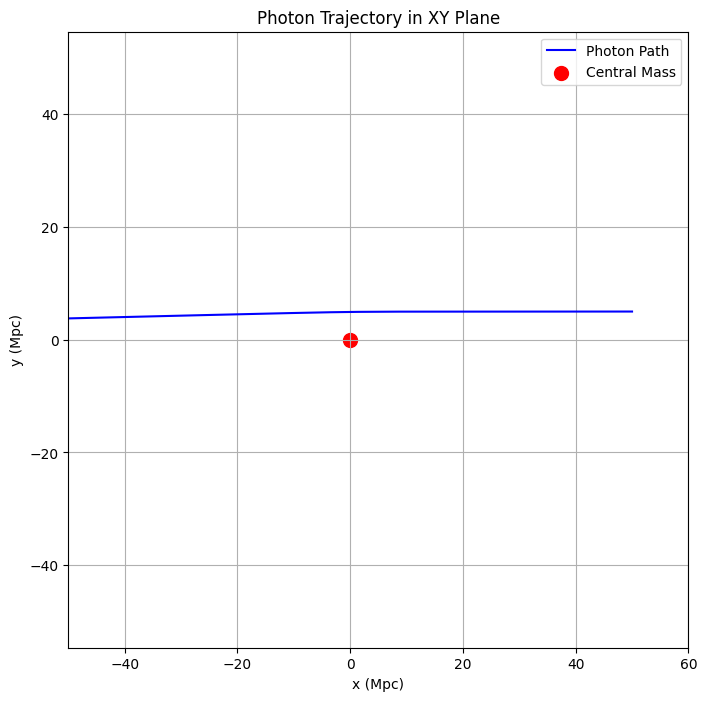

In [31]:
# XY plane trajectory
plt.figure(figsize=(8, 8))
plt.plot(x, y, color='blue', label='Photon Path')
plt.scatter([0], [0], color='red', s=100, label='Central Mass')
plt.xlabel('x (Mpc)')
plt.ylabel('y (Mpc)')
plt.title('Photon Trajectory in XY Plane')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.xlim(-50, 60)
plt.ylim(-10, 10)
plt.show()


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


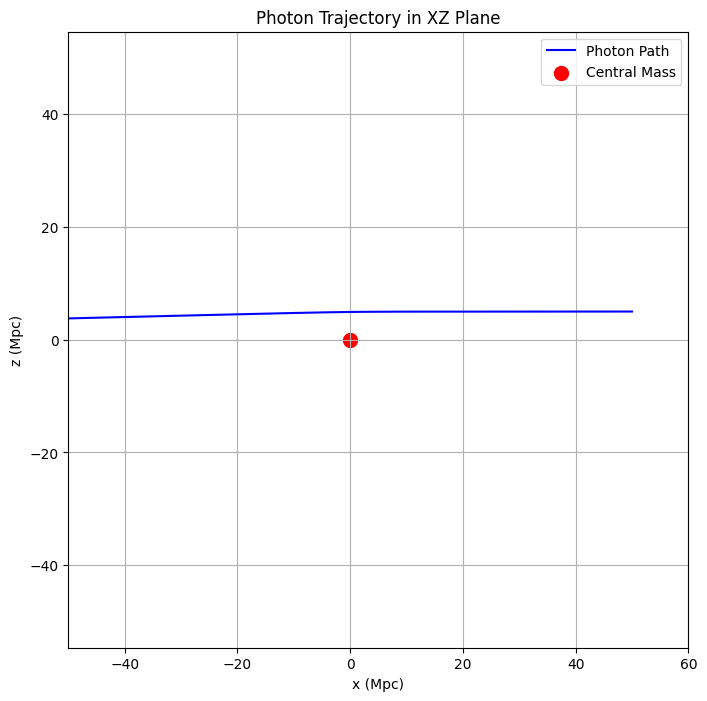

In [32]:
# XZ plane trajectory
plt.figure(figsize=(8, 8))
plt.plot(x, z, color='blue', label='Photon Path')
plt.scatter([0], [0], color='red', s=100, label='Central Mass')
plt.xlabel('x (Mpc)')
plt.ylabel('z (Mpc)')
plt.title('Photon Trajectory in XZ Plane')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.xlim(-50, 60)
plt.ylim(-10, 10)
plt.show()